# Getting started with Task 1

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## The PTB Diagnostic ECG Database

- Number of Samples: 14552
- Number of Categories: 2
- Sampling Frequency: 125Hz
- Data Source: Physionet's PTB Diagnostic Database
- ECG lead II re-sampled to the sampling frequency of 125Hz as the input (from [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf))
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the normal dataframe is :  (4046, 188)
Class :  0.0
The shape of the abnormal dataframe is :  (10506, 188)
Class :  1.0
The last time value is :  1488.0


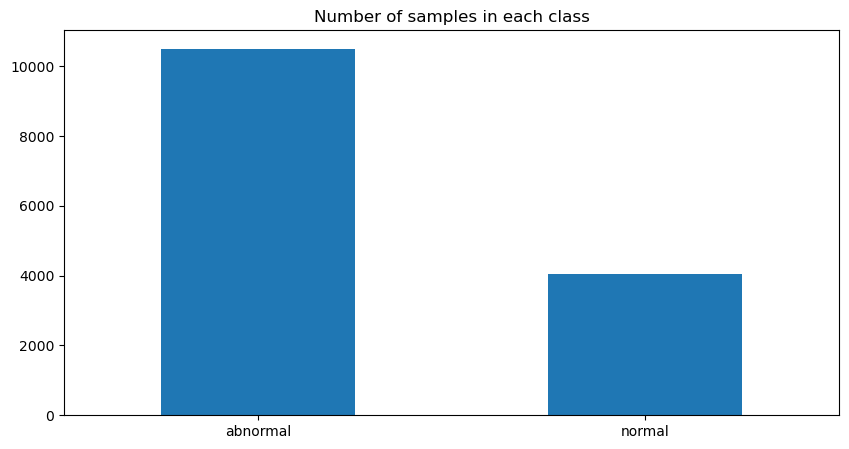

In [87]:
df_ptbd_normal = pd.read_csv("../ecg_dataset/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv("../ecg_dataset/ptbdb_abnormal.csv", header = None)

# print shapes of the dataframes
print("The shape of the normal dataframe is : ", df_ptbd_normal.shape)
# print one example of the last column
print("Class : ", df_ptbd_normal.iloc[:, -1][0])
print("The shape of the abnormal dataframe is : ", df_ptbd_abnormal.shape)
# print one example of the last column
print("Class : ", df_ptbd_abnormal.iloc[:, -1][0])

# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal", 
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1 
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]

# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)
# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()

In [88]:
from sklearn.model_selection import train_test_split

x = df_ptbd.loc[:, df_ptbd.columns != "label"]
y = df_ptbd.loc[:, df_ptbd.columns == "label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle = True)


In [89]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

In [90]:
class NeuralNetwork(): 

    def __init__(self, learning_rate):
        self.weights = np.array([np.random.randn() for i in range(187)])
        self.bias = np.random.randn()
        self.learning_rate = learning_rate
        
    def sigmoidFunc(self, x):
        return (1/(1+np.exp(-x)))

    def sigmoidFuncDerivative(self, x):
        return (self.sigmoidFunc(x))*(1-self.sigmoidFunc(x))

    def makePrediction(self, input_vector):
        layer1 = np.dot(input_vector, self.weights) + self.bias 
        layer2 = self.sigmoidFunc(layer1)
        
        return layer2

    def computeGradients(self, input_vector, target):
        layer1 = np.dot(input_vector, self.weights) + self.bias 
        layer2 = self.sigmoidFunc(layer1)
        prediction = layer2

        derror_dprediction = 2*(prediction - target)
        dprediction_dlayer1 = self.sigmoidFuncDerivative(layer1)
        dlayer_dbias = 1
        dlayer_dweights = (0*self.weights) + (1 * input_vector)

        derror_dbias = derror_dprediction * dprediction_dlayer1 * dlayer_dbias
        derror_dweights = derror_dprediction * dprediction_dlayer1 * dlayer_dweights

        return derror_dbias, derror_dweights

    def updateParameters(self, derror_dbias, derror_dweights):
        self.bias = self.bias - (derror_dbias * self.learning_rate)
        self.weights = self.weights - (derror_dweights * self.learning_rate)

    def train(self, inputs, target):
        iteration = len(inputs)

        for i in range(iteration):
            derror_dbias, derror_dweights = self.computeGradients(inputs[i], target[i])
            self.updateParameters(derror_dbias, derror_dweights)
            
    def predictionMatrix(self, inputs, target):
        iteration = len(inputs)
        predictions = []
        
        for i in range(iteration):
            predictions.append(self.makePrediction(inputs[i]))
            
        for i in range(len(predictions)):
            if(predictions[i] >= 0.5):
                predictions[i] = 1
            else:
                predictions[i] = 0
                
        return predictions

    def score(self, predictions, target):
        
        temp1 = np.array(predictions)
        temp2 = y_test.flatten()
        temp2 = temp2.astype(int)
        temp1 = temp1 - temp2
        temp1 = abs(temp1)
        
        return (1 - (sum(temp1)/len(temp1)))

In [91]:
mynn = NeuralNetwork(0.1)
mynn.train(x_train, y_train)
answer = mynn.predictionMatrix(x_test, y_test)

mynn.score(answer, y_train)

0.8069170865781035

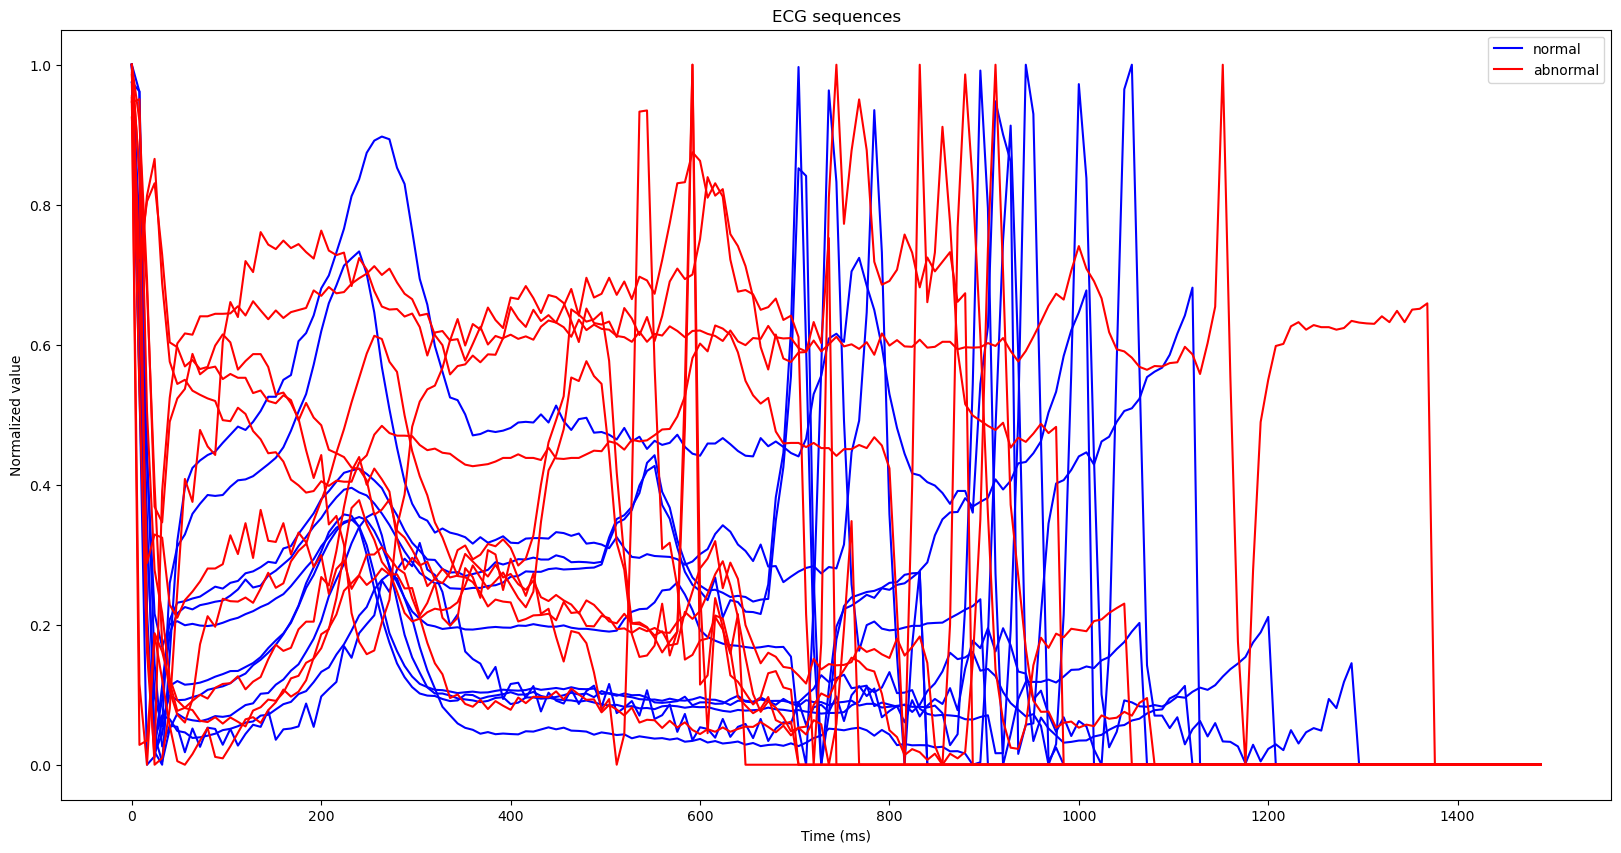

In [255]:
# plot a a row of the dataframe
# select 10 random sequences with class 0 (normal) and 10 with class 1 (abnormal)
df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(10)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(10)

# create a figure
plt.figure(figsize = (20, 10))
# plot againts the column names (time)
# plot the normal sequences
for i in range(df_ptbd_normal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1], color = "blue", label = "normal")
    else:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1],color = "blue")
# plot the abnormal sequences
for i in range(df_ptbd_abnormal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red", label = "abnormal")
    else:   
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red")
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()